In [1]:
import json
from typing import List, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import src.preprocessing as preprocessing
from src.files_io import download_and_extract_raw_datasets, load_raw_population_datasets

In [2]:
download_and_extract_raw_datasets()

Raw Datasets already exists.


# Population Data
We start by analyzing the general population dataset and then apply the pre-processing on the customer dataset.

In [3]:
population, _ = load_raw_population_datasets()

Population datasets loaded.


In [4]:
meta = preprocessing.load_meta_data(raw_file_path="./data/meta/dias_values.xlsx")

Metadata loaded.


## Data Types

In [5]:
population.dtypes.value_counts()

float64    267
int64       93
object       6
Name: count, dtype: int64

### String Types
Besides numeric values there are strings in the datasets which need a separate preprocessing:
- `cameo_deu_2015`, `cameo_deug_2015` and `cameo_intl_2015`
  - have `X` or `XX` values that should be treated as null values
  - partially have numeric values as strings that should be unified
- `d19_letzter_kauf_branche` shows the sector of the last purchase which is probably ineligible for our segmentation report and prediction model
- `eingefuegt_am` is the timestamp where the data was created in the database and also unnecessary
- `ost_west_kz` is a flag labeled as `W` or `O` that should be converted to a binary numeric value 0/1

In [6]:
population.select_dtypes(include="object").head()

,cameo_deu_2015,cameo_deug_2015,cameo_intl_2015,d19_letzter_kauf_branche,eingefuegt_am,ost_west_kz
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


In [7]:
population["cameo_deu_2015"].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [8]:
population["cameo_deug_2015"].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [9]:
population["cameo_intl_2015"].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [10]:
population["ost_west_kz"].unique()

array([nan, 'W', 'O'], dtype=object)

In [11]:
population = population.drop(columns=["d19_letzter_kauf_branche", "eingefuegt_am"])

### Unified Numerical Types
All numerical values in the dataset are actually integers, but Pandas converted most of them to float to be able to handle null values.

Furthermore, many of the numerical columns are actually categorical variables, which will be addressed with one-hot-encoding at the end of the pre-processing. However, we will start by converting all integer values to floats, because it simplifies the initial preprocessing.

In [12]:
int_cols = population.select_dtypes(include=int).columns
population[int_cols] = population[int_cols].astype(float)

## Missing Values
Before analyzing the missing values we start by converting unknown and invalid values to null in order to be able to handle them as missing data.

### Unknown Values
The provided meta information list that explains the meanings of the numeric attribute values can be used to identify unknown values.

#### Missing Population Attributes
- some attribute names have to be rectified to map them with the population dataset
- but these attributes from the meta list couldn't be assigned/found in the population dataset: `bip_flag`, `geoscore_kls7`, `haushaltsstruktur`, `wachstumsgebiet_nb`


In [13]:
meta[meta["meaning"].str.contains("unknown")]

,attribute,description,value,meaning
0,ager_typ,best-ager typology,-1,unknown
5,alterskategorie_grob,age classification through prename analysis,-1,unknown
5,alterskategorie_grob,age classification through prename analysis,0,unknown
11,alter_hh,main age within the household,0,unknown / no main age detectable
33,anrede_kz,gender,-1,unknown
...,...,...,...,...
2238,wachstumsgebiet_nb,growing area (population growth in the last 5 ...,0,unknown
2244,w_keit_kind_hh,likelihood of a child present in this household,-1,unknown
2244,w_keit_kind_hh,likelihood of a child present in this household,0,unknown
2251,zabeotyp,typification of energy consumers,-1,unknown


In [14]:
def identify_missing_population_attributes(meta: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    missing_population_attributes = list(set(meta["attribute"].unique()).difference(df.columns))
    missing_population_attributes.sort()
    return missing_population_attributes

identify_missing_population_attributes(meta, population)

['bip_flag',
 'd19_banken_direkt_rz',
 'd19_banken_gross_rz',
 'd19_banken_lokal_rz',
 'd19_banken_rest_rz',
 'd19_bekleidung_geh_rz',
 'd19_bekleidung_rest_rz',
 'd19_bildung_rz',
 'd19_bio_oeko_rz',
 'd19_buch_rz',
 'd19_digit_serv_rz',
 'd19_drogerieartikel_rz',
 'd19_energie_rz',
 'd19_freizeit_rz',
 'd19_garten_rz',
 'd19_handwerk_rz',
 'd19_haus_deko_rz',
 'd19_kinderartikel_rz',
 'd19_kk_kundentyp',
 'd19_kosmetik_rz',
 'd19_lebensmittel_rz',
 'd19_lotto_rz',
 'd19_nahrungsergaenzung_rz',
 'd19_ratgeber_rz',
 'd19_reisen_rz',
 'd19_sammelartikel_rz',
 'd19_schuhe_rz',
 'd19_sonstige_rz',
 'd19_technik_rz',
 'd19_telko_mobile_rz',
 'd19_telko_rest_rz',
 'd19_tierartikel_rz',
 'd19_versand_rest_rz',
 'd19_versicherungen_rz',
 'd19_vollsortiment_rz',
 'd19_wein_feinkost_rz',
 'geoscore_kls7',
 'haushaltsstruktur',
 'kba13_ccm_1400_2500',
 'soho_flag',
 'wachstumsgebiet_nb']

In [15]:
meta = preprocessing.rectify_meta_attributes(meta)

Metadata rectified.


In [16]:
identify_missing_population_attributes(meta, population)

['bip_flag', 'geoscore_kls7', 'haushaltsstruktur', 'wachstumsgebiet_nb']

In [17]:
population = preprocessing.convert_unknown_values_to_null(population, meta)

Converted 324 unknown values from the meta information to null in the dataset.


#### Population Attributes without Meta Information
- 54 columns from the population dataset are not included in the provided meta information
- there are no remaining -1 values found, where the chance is high that they represent unknown values
- `lnr` is an identifier for the dataset records and should be removed

In [18]:
def identify_missing_meta_attributes(df: pd.DataFrame, meta: pd.DataFrame) -> pd.DataFrame:
    missing_meta_attributes = list(set(df.columns).difference(meta["attribute"].unique()))

    missing_meta_attributes.sort()

    excluded_attributes = [
        "cameo_wealth",
        "cameo_life_phase",
        "youth_decade",
        "youth_orientation",
    ]

    for exclude_attribute in excluded_attributes:
        if exclude_attribute in missing_meta_attributes:
            missing_meta_attributes.remove(exclude_attribute)

    return missing_meta_attributes

missing_meta_attributes = identify_missing_meta_attributes(population, meta)

population[missing_meta_attributes].describe()

,akt_dat_kl,alter_kind1,alter_kind2,alter_kind3,alter_kind4,alterskategorie_fein,anz_kinder,anz_statistische_haushalte,arbeit,cjt_katalognutzer,...,strukturtyp,umfeld_alt,umfeld_jung,ungleichenn_flag,verdichtungsraum,vha,vhn,vk_dht4a,vk_distanz,vk_zg11
count,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,794005.000000,886367.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,3.167854,3.335264,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,1.002376,1.493633,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,3.000000,2.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,4.000000,5.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,9.000000,5.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [19]:
assert sum(sum(population.values == -1)) == 0

In [20]:
population = population.drop(columns=["lnr"])

### Invalid Values
#### Counts & Dates
Some counts and dates are logically invalid and should be replaced with null values:
- `geburtsjahr` is the year of birth and has invalid 0 values
- `anz_personen` are the number of adult persons in the household and has invalid 0 values although e.g. the year of birth shows that there are indeed adults

In [21]:
meta[meta["meaning"].str.contains("numeric")]

,attribute,description,value,meaning
36,anz_haushalte_aktiv,number of households in the building,…,numeric value (typically coded from 1-10)
37,anz_hh_titel,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,anz_personen,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,anz_titel,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,geburtsjahr,year of birth,…,numeric value
1167,kba13_anzahl_pkw,number of cars in the PLZ8,…,numeric value
1986,min_gebaeudejahr,year the building was first mentioned in our d...,…,numeric value


In [22]:
year_columns = population.columns[population.columns.str.contains("jahr")]

population[year_columns].describe()

,eingezogenam_hh_jahr,geburtsjahr,min_gebaeudejahr,praegende_jugendjahre
count,817722.000000,891221.000000,798073.000000,783057.000000
mean,2003.729061,1101.178533,1993.277011,9.280709
std,7.058204,976.583551,3.332739,4.032107
min,1900.000000,0.000000,1985.000000,1.000000
25%,1997.000000,0.000000,1992.000000,6.000000
50%,2003.000000,1943.000000,1992.000000,9.000000
75%,2010.000000,1970.000000,1993.000000,14.000000
max,2018.000000,2017.000000,2016.000000,15.000000


In [23]:
population["geburtsjahr"].value_counts()

geburtsjahr
0.0       392318
1967.0     11183
1965.0     11090
1966.0     10933
1970.0     10883
           ...  
1909.0         7
1904.0         5
1900.0         4
1907.0         4
1902.0         1
Name: count, Length: 117, dtype: int64

In [24]:
count_columns = population.columns[population.columns.str.startswith("anz_") | population.columns.str.contains("anzahl")]

population[count_columns].describe()

,anz_haushalte_aktiv,anz_hh_titel,anz_kinder,anz_personen,anz_statistische_haushalte,anz_titel,kba13_anzahl_pkw
count,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,785421.000000
mean,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,619.701439
std,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,340.034318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,384.000000
50%,4.000000,0.000000,0.000000,1.000000,3.000000,0.000000,549.000000
75%,9.000000,0.000000,0.000000,2.000000,9.000000,0.000000,778.000000
max,595.000000,23.000000,11.000000,45.000000,449.000000,6.000000,2300.000000


In [25]:
population[population["anz_personen"] == 0]["geburtsjahr"]

3         1957.0
16        1988.0
25        1991.0
64        1975.0
80        1974.0
           ...  
891128    1963.0
891154       0.0
891169       0.0
891203       0.0
891218    1976.0
Name: geburtsjahr, Length: 34103, dtype: float64

#### Out of Meta Information Range
Some values are not included in the ranges from the given meta information, we will therefore handle them as null values.

In [26]:
_ = preprocessing.identify_invalid_out_of_range_values(meta, population, log_details=True)

attribute: kba05_modtemp, invalid value: 6.0, affected rows: 9549
attribute: lp_familie_fein, invalid value: 0.0, affected rows: 72938
attribute: lp_familie_grob, invalid value: 0.0, affected rows: 72938
attribute: lp_lebensphase_fein, invalid value: 0.0, affected rows: 92778
attribute: lp_lebensphase_grob, invalid value: 0.0, affected rows: 89718
attribute: ortsgr_kls9, invalid value: 0.0, affected rows: 58


In [27]:
population = preprocessing.convert_invalid_values_to_null(population, meta)

Converted 8 invalid values to null in the dataset.


### Remove Rows
Around 12% of all data records have more than 120 missing attributes (so over one third of the features), which will be removed due to the lack of information.

In [28]:
print(f"Share of records with more than 33% missing data:"
      f"\nPopulation: {sum(population.isnull().sum(axis=1) / len(population.columns) >= .33) / len(population) * 100:.1f}%")

Share of records with more than 33% missing data:
Population: 11.9%


In [29]:
def plot_histogram_missing_value_counts_per_record(df: pd.DataFrame) -> None:
    """
    Plots histogram of missing value counts per record.

    :param df: Dataset with missing value counts.
    """
    missing_value_counts = df.isnull().sum(axis=1).value_counts().reset_index()
    missing_value_counts.columns = ["count_missing_values", "data_records"]

    plt.figure(figsize=(15, 4))
    plt.bar(missing_value_counts["count_missing_values"], missing_value_counts["data_records"], width=0.8, color="royalblue")

    plt.title("Distribution of Missing Value Counts Per Record")
    plt.xlabel("Count of Missing Values")
    plt.ylabel("Data Records")

    plt.show()

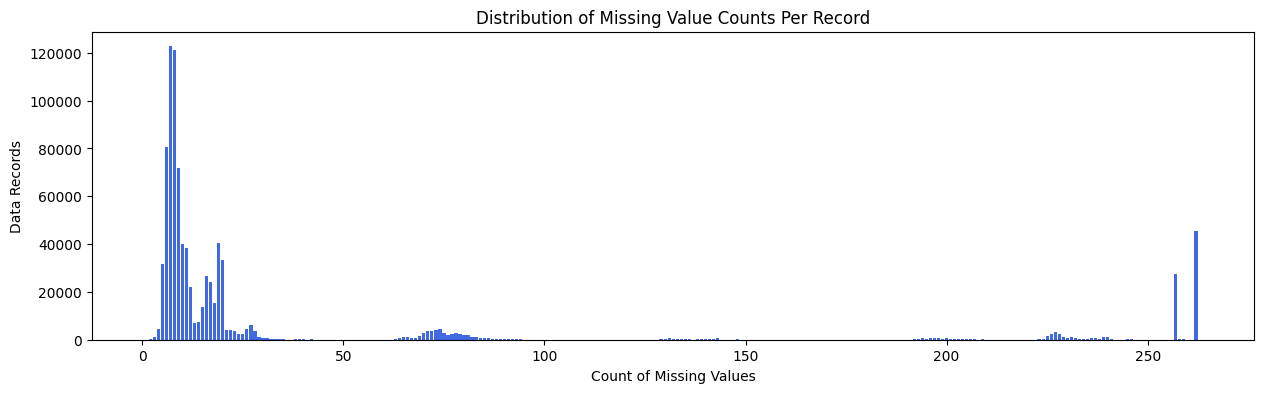

In [30]:
plot_histogram_missing_value_counts_per_record(population)

In [31]:
population = preprocessing.remove_records_with_insufficient_data(population)

Removed 105801 records with over 33.0% missing feature values.


### Impute or Remove Columns
- `alter_kind1` to `alter_kind4` are largely null because most of the persons in the dataset haven't kids
  - nevertheless the age of the kids can provide useful information
  - we will remove `alter_kind3` and `alter_kind4` which have over 99% missing values
  - null values for `alter_kind1` and `alter_kind2` will be imputed with 0
- `titel_kz` is a flag for an academic title, so the high ratio of over 99% missing values is probably correct
  - the data differentiates between various academic titles, which we will simplify to a binary flag (academic title yes or no) to limit the dimensionality
- `ager_typ` is a classification for older people, so the high ratio of missing values (~74%) is reasonable
  - the max birth year for all records with an ager classification is 1959
  - we impute all missing `ager_typ` with its median if the `geburtsjahr` is lower or equal 1959
  - all other null values will be replaced with -1, which represents an own class in the one-hot-encoding
- all attributes with a ratio over 20% missing values (14 attributes) will be completely dropped, because there is no logical reason for the missing data and an uncertain imputation for that amount of data will possibly create too much bias
- the remaining attributes have a max ratio of 7.5%, which we will keep in the dataset and impute the null values with its median for numeric types and mode for strings

In [32]:
missing_values_ratio = pd.Series(round(population.isnull().sum() / len(population) * 100, 1).sort_values(ascending=False), name="missing_values_ratio")
missing_values_ratio

alter_kind4          99.9
titel_kz             99.7
alter_kind3          99.2
alter_kind2          96.4
alter_kind1          90.0
                     ... 
kba13_bj_2006         0.0
kba13_bj_2004         0.0
kba13_bj_2000         0.0
kba13_bj_1999         0.0
d19_banken_anz_12     0.0
Name: missing_values_ratio, Length: 363, dtype: float64

In [33]:
population[missing_values_ratio[missing_values_ratio >= 20.0].index].describe()

,alter_kind4,titel_kz,alter_kind3,alter_kind2,alter_kind1,ager_typ,extsel992,kk_kundentyp,kba05_baumax,geburtsjahr,alter_hh,alterskategorie_fein,d19_konsumtyp,d19_banken_online_quote_12,d19_gesamt_online_quote_12,d19_telko_online_quote_12,d19_versi_online_quote_12,d19_soziales,d19_versand_online_quote_12,d19_lotto
count,1165.000000,2048.000000,5985.000000,28519.000000,78157.000000,206683.000000,229801.000000,294880.000000,412001.000000,480658.000000,560062.000000,605811.000000,610264.000000,610264.000000,610264.000000,610264.000000,610264.000000,610264.000000,610264.000000,610264.000000
mean,15.094421,1.315918,14.476358,13.415512,11.766700,1.662183,33.357753,3.410550,2.531436,1967.060810,15.291193,13.690420,5.424528,0.705817,3.556028,0.012367,0.025279,0.664235,3.239123,1.534826
std,2.451526,0.996477,2.713507,3.238147,4.085296,0.743813,14.530266,1.628902,1.690418,17.797858,3.804053,5.079973,3.234337,2.553706,4.656783,0.350347,0.498384,1.462815,4.584298,2.841457
min,7.000000,1.000000,4.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,1.000000,13.000000,11.000000,8.000000,1.000000,23.000000,2.000000,1.000000,1955.000000,13.000000,11.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,1.000000,15.000000,14.000000,12.000000,2.000000,34.000000,3.000000,1.000000,1967.000000,16.000000,14.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,1.000000,17.000000,16.000000,15.000000,2.000000,43.000000,5.000000,4.000000,1981.000000,18.000000,17.000000,9.000000,0.000000,10.000000,0.000000,0.000000,0.000000,10.000000,0.000000
max,18.000000,5.000000,18.000000,18.000000,18.000000,3.000000,56.000000,6.000000,5.000000,2017.000000,21.000000,25.000000,9.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000,7.000000


In [34]:
population[population["ager_typ"].notnull()]["geburtsjahr"].max()

np.float64(1959.0)

In [35]:
population = preprocessing.impute_or_remove_features_with_missing_values(population)

Removed 16 features with over 20.0% missing values:
alter_hh, alter_kind3, alter_kind4, alterskategorie_fein, d19_banken_online_quote_12, d19_gesamt_online_quote_12, d19_konsumtyp, d19_lotto, d19_soziales, d19_telko_online_quote_12, d19_versand_online_quote_12, d19_versi_online_quote_12, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 129 features.


## Feature Extraction
### Formative Youth Years
The attribute `praegende_jungendjahre` (formative youth years) contains multiple information that could be worth to split into multiple youth features:
- `youth_decade`: the decade represented as 40 for '40ies', 50 for '50ies' and so on
- `youth_orientation`: mainstream or avantgarde

In [36]:
population = preprocessing.split_formative_youth_years(population, meta)

Extracted decade and cultural orientation as separate features.


### Wealth & Life Phase
The attribute `cameo_intl_2015` is a composition of wealth and life phase and should be separated:
- `cameo_wealth`: the first digit represents the wealth (from wealthy to poor households)
- `cameo_life_phase`: the second digit stands for the life phase (from pre-family singles to elders in retirement)

In [37]:
population = preprocessing.split_international_cameo(population)

Extracted wealth and life phase as separate features.


## Dimensionality Reduction
It is useful to drop redundant features to improve the model performance and reduce overfitting. We can identify them with a feature correlation analysis, where highly correlated features indicates that there is redundancy.

These features have a strong correlation of over 0.9, so we will drop one of them:
- `anz_haushalte_aktiv` and `anz_statistische_haushalte` have also quite similar names
- `cameo_deug_2015` and the extracted wealth from `cameo_intl_2015`, whereby `cameo_deug_2015` have more detailed social classes
- `gemeindetyp`, `ewdichte` and `ortsgr_kls9` - we only retain `ortsgr_kls9`
- `lp_familie_fein`, `lp_familie_grob`, `lp_lebensphase_fein` and `lp_lebensphase_grob` are all correlated by each other - we will only keep `lp_familie_fein` (= accurate family type)
- `lp_status_fein` and `lp_status_grob`, whereby `lp_status_fein` have a more detailed social
- all `plz8_` features are already covered by `kba13_` (both representing data from postal area code 8xxxx)
- between the transactional activities and actuality of the last transaction from the `d19_` attributes exists a redundancy
  - we prefer the more general columns over specific ones, e.g. `gesamt` over `versand` or `telko`
  - we prefer the 24-month over the 12-month features to have a more complete picture
- there is a surprising correlation between the gender feature `anrede_kz` and `semio_kaem` (= affinity to fightfull attitude) as well as `semio_vert` (affinity to be dreamily) - but we will keep the gender feature anyway

In [38]:
def identify_highly_correlated_features(df: pd.DataFrame, correlation_threshold: float) -> pd.DataFrame:
    corr_matrix = df.select_dtypes([float, int]).corr().abs()

    highly_correlated_features = []

    for f1 in range(corr_matrix.shape[1]):
        for f2 in range(f1 + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[f1, f2] >= correlation_threshold:
                feature_1 = corr_matrix.columns[f1]
                feature_2 = corr_matrix.columns[f2]
                highly_correlated_features.append((feature_1, feature_2, corr_matrix.iloc[f1, f2]))

    if highly_correlated_features:
        print(f"Feature pairs with a correlation of {correlation_threshold} or higher:")
        for pair in highly_correlated_features:
            print(f"({pair[0]}, {pair[1]}): {pair[2]:.2f}")
    else:
        print(f"No feature pairs found with a correlation of {correlation_threshold} or higher.")

    return corr_matrix


corr_matrix = identify_highly_correlated_features(population, correlation_threshold=0.8)

Feature pairs with a correlation of 0.8 or higher:
(anz_haushalte_aktiv, anz_statistische_haushalte): 0.98
(cameo_deug_2015, cameo_wealth): 0.97
(cjt_typ_1, cjt_typ_2): 0.89
(cjt_typ_1, cjt_typ_5): 0.80
(d19_banken_anz_12, d19_banken_anz_24): 0.82
(d19_banken_anz_24, d19_banken_datum): 0.81
(d19_banken_datum, d19_banken_online_datum): 0.89
(d19_gesamt_anz_12, d19_gesamt_anz_24): 0.90
(d19_gesamt_anz_12, d19_gesamt_datum): 0.82
(d19_gesamt_anz_12, d19_versand_anz_12): 0.90
(d19_gesamt_anz_12, d19_versand_anz_24): 0.85
(d19_gesamt_anz_24, d19_gesamt_datum): 0.86
(d19_gesamt_anz_24, d19_gesamt_online_datum): 0.84
(d19_gesamt_anz_24, d19_versand_anz_12): 0.83
(d19_gesamt_anz_24, d19_versand_anz_24): 0.92
(d19_gesamt_anz_24, d19_versand_datum): 0.82
(d19_gesamt_anz_24, d19_versand_online_datum): 0.81
(d19_gesamt_datum, d19_gesamt_online_datum): 0.89
(d19_gesamt_datum, d19_konsumtyp_max): 0.82
(d19_gesamt_datum, d19_versand_datum): 0.87
(d19_gesamt_datum, d19_versand_online_datum): 0.83
(d19

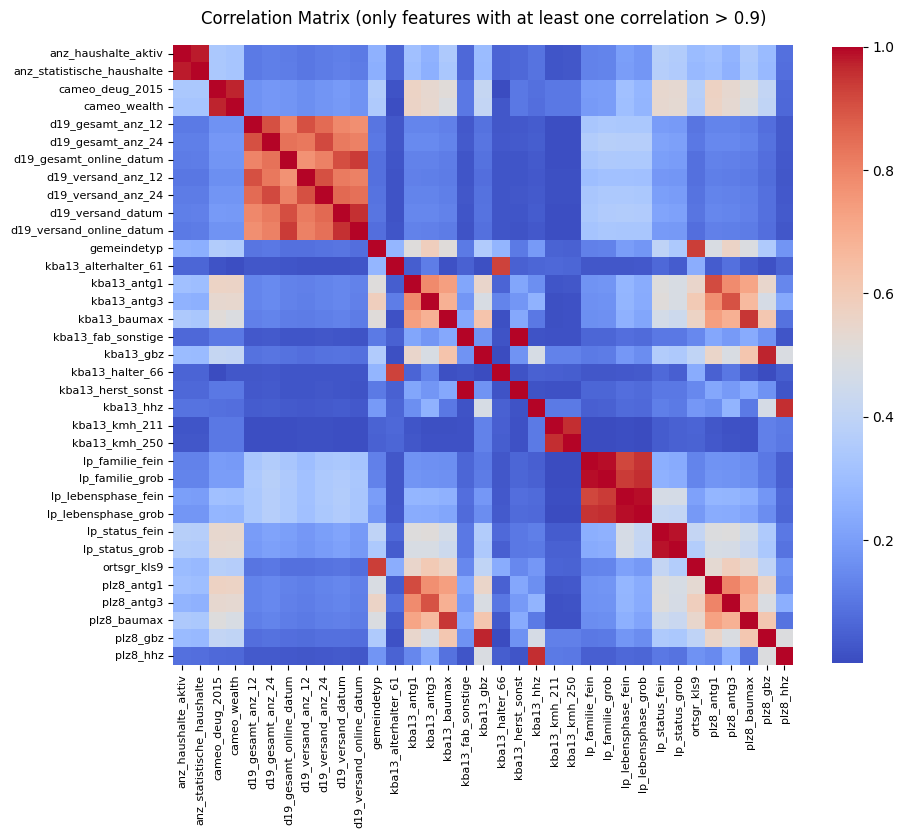

In [67]:
def plot_correlation_matrix(matrix: pd.DataFrame, correlation_threshold: float) -> None:
    matrix_gt_threshold = set()

    for f1 in range(matrix.shape[1]):
        for f2 in range(f1 + 1, matrix.shape[1]):
            if matrix.iloc[f1, f2] > correlation_threshold:
                feature_1 = matrix.columns[f1]
                feature_2 = matrix.columns[f2]
                matrix_gt_threshold.add(feature_1)
                matrix_gt_threshold.add(feature_2)

    matrix_gt_threshold = sorted(list(matrix_gt_threshold))
    matrix = matrix.loc[matrix_gt_threshold, matrix_gt_threshold]

    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=False, cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

    plt.title(f"Correlation Matrix (only features with at least one correlation > {correlation_threshold})", pad=15)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)

    plt.show()

plot_correlation_matrix(corr_matrix, 0.9)

In [68]:
with open("./src/feature_config.json", "r") as f:
    feature_config = json.load(f)

In [69]:
feature_config["redundant"]

['anz_statistische_haushalte',
 'cameo_wealth',
 'd19_banken_anz_12',
 'd19_banken_datum',
 'd19_gesamt_anz_12',
 'd19_gesamt_datum',
 'd19_gesamt_offline_datum',
 'd19_gesamt_online_datum',
 'd19_versand_anz_12',
 'd19_versand_anz_24',
 'd19_versand_datum',
 'd19_versand_offline_datum',
 'd19_versand_online_datum',
 'd19_telko_datum',
 'd19_versi_anz_12',
 'd19_versi_datum',
 'ewdichte',
 'finanz_sparer',
 'gemeindetyp',
 'green_avantgarde',
 'kba05_gbz',
 'kba05_krsherst1',
 'kba05_krsherst2',
 'kba05_krsherst3',
 'kba05_krsklein',
 'kba05_krsober',
 'kba05_krszul',
 'kba13_alterhalter_30',
 'kba13_alterhalter_45',
 'kba13_alterhalter_60',
 'kba13_alterhalter_61',
 'kba13_antg1',
 'kba13_antg2',
 'kba13_antg3',
 'kba13_antg4',
 'kba13_baumax',
 'kba13_gbz',
 'kba13_herst_sonst',
 'kba13_hhz',
 'kba13_vw',
 'kba13_mercedes',
 'kba13_kmh_140',
 'kba13_kmh_250',
 'kba13_seg_grossraumvans',
 'kba13_seg_kleinst',
 'kba13_seg_minivans',
 'kba13_sitze_4',
 'lp_familie_grob',
 'lp_lebensphas

In [70]:
# for demonstration purposes we remove "green_avantgarde" from the config, because we identified that redundant feature later
feature_config["redundant"].remove("green_avantgarde")

In [71]:
population = preprocessing.remove_features(population, feature_config, ["redundant"])

Removed 50 redundant features.


## Feature Transformation
### Classification based on Meta Information

The meta information to each attributes value is crucial to decide how to handle and transform a feature.

- if the values are not ordinal (no perceived order), we will classify it as a categorical feature, e.g. `finanztyp` or `gfk_urlaubertyp`
  - except binary features, because one-hot-encoding would only add a dimension without adding new information, e.g. `soho_kz`
  - so binary features only need to be converted if they are not yet present as 0 and 1, e.g. `ost_west_kz`
- if the values are obviously ordinal but the distances between are not perfectly equal or not clearly assessable, we will retain it as a numerical feature to limit the dimensionality, e.g. `regiotyp` or `cameo_deug_2015`
- unambiguous numerical features will of course be retained as they are, e.g. `anz_personen` or `min_gebaeudejahr`
meta[meta["attribute"] == "gfk_urlaubertyp"]

In [72]:
meta[meta["attribute"] == "soho_kz"]

,attribute,description,value,meaning
2207,soho_kz,small office/home office flag,-1,unknown
2208,soho_kz,small office/home office flag,0,no small office/home office
2209,soho_kz,small office/home office flag,1,small office/home office


In [73]:
meta[meta["attribute"] == "regiotyp"]

,attribute,description,value,meaning
2070,regiotyp,neighbourhood,-1,unknown
2070,regiotyp,neighbourhood,0,unknown
2071,regiotyp,neighbourhood,1,upper class
2072,regiotyp,neighbourhood,2,conservatives
2073,regiotyp,neighbourhood,3,upper middle class
2074,regiotyp,neighbourhood,4,middle class
2075,regiotyp,neighbourhood,5,lower middle class
2076,regiotyp,neighbourhood,6,traditional workers
2077,regiotyp,neighbourhood,7,marginal groups


### Classification without Meta Information

Attributes without meta information are more difficult to decide how to appropriately handle them. These rules have been applied:
- if an attribute has only two values then it is handled as a binary categorical feature
  - 3 of 4 have the suffix "flag" and they have only 0/1 values, which supports the assumption
- attributes with "anz_" (= count) or "alter_" (= age) prefix a clearly numeric features
- `eingezogenam_hh_jahr` has year values and also clearly numeric
- `cjt_` attributes are subtypes of `cjt_gesamttyp` (= total type of customer journey typology)
  - because of the uncertainty we will remove the subtypes and only take the total type
- `d19_` attributes that ends with "_datum" is a repetitive pattern and therefore probably ordinal categories, that we retain as numeric feature
- `firmendichte` is a density whose values 1-5 probably stands for ordered cluster with density intervals analogue to the feature `ewdichte`, that we therefore retain as numeric feature
- `kba13_` attributes have similar ranges like the other kba13 features, which all have a perceived order, so we will keep these attributes as well as numeric features
- the remaining 18 attributes will be left out due to uncertainty

In [74]:
missing_meta_attributes = identify_missing_meta_attributes(population, meta)

missing_meta_attributes

['akt_dat_kl',
 'alter_kind1',
 'alter_kind2',
 'anz_kinder',
 'arbeit',
 'cjt_katalognutzer',
 'cjt_typ_1',
 'cjt_typ_2',
 'cjt_typ_3',
 'cjt_typ_4',
 'cjt_typ_5',
 'cjt_typ_6',
 'd19_konsumtyp_max',
 'd19_versi_offline_datum',
 'd19_versi_online_datum',
 'dsl_flag',
 'eingezogenam_hh_jahr',
 'firmendichte',
 'hh_delta_flag',
 'kba13_kmh_210',
 'kombialter',
 'konsumzelle',
 'mobi_raster',
 'rt_kein_anreiz',
 'rt_schnaeppchen',
 'rt_uebergroesse',
 'strukturtyp',
 'umfeld_alt',
 'umfeld_jung',
 'ungleichenn_flag',
 'verdichtungsraum',
 'vha',
 'vhn',
 'vk_dht4a',
 'vk_distanz',
 'vk_zg11']

In [75]:
population.loc[:, list(set(population.columns[population.nunique() <= 2]).intersection(missing_meta_attributes))].describe()

,konsumzelle,dsl_flag,hh_delta_flag,ungleichenn_flag
count,785420.000000,785420.000000,785420.000000,785420.000000
mean,0.235073,0.974089,0.089567,0.089709
std,0.424045,0.158870,0.285561,0.285764
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [76]:
population["arbeit"].value_counts()

arbeit
4.0    306818
3.0    255126
2.0    133104
1.0     55520
5.0     34698
9.0       154
Name: count, dtype: int64

In [77]:
population[[col for col in missing_meta_attributes if "cjt_" in col]].describe()

,cjt_katalognutzer,cjt_typ_1,cjt_typ_2,cjt_typ_3,cjt_typ_4,cjt_typ_5,cjt_typ_6
count,785420.000000,785420.000000,785420.000000,785420.000000,785420.000000,785420.000000,785420.000000
mean,3.229035,3.271834,3.088677,3.264977,3.248060,3.264374,3.389108
std,1.479079,1.346265,1.371093,1.374899,1.348528,1.357284,1.313104
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000
75%,5.000000,5.000000,4.000000,5.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [78]:
population[[col for col in missing_meta_attributes if "d19_" in col]].describe()

,d19_konsumtyp_max,d19_versi_offline_datum,d19_versi_online_datum
count,785420.000000,785420.000000,785420.000000
mean,5.559611,9.915123,9.974536
std,3.219576,0.526205,0.325291
min,1.000000,1.000000,1.000000
25%,2.000000,10.000000,10.000000
50%,8.000000,10.000000,10.000000
75%,8.000000,10.000000,10.000000
max,9.000000,10.000000,10.000000


In [79]:
population[[col for col in missing_meta_attributes if "kba13_" in col]].describe()

,kba13_kmh_210
count,785420.000000
mean,3.037304
std,0.955909
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


### Encode Binary Features
Convert binary features if their values are not already 0 or 1.

In [80]:
binary_features = feature_config["binary"]

population = preprocessing.encode_binary_features(population, binary_features)

Encoded 10 binary features.


In [81]:
population[binary_features].agg(["min", "max"])

,anrede_kz,dsl_flag,hh_delta_flag,konsumzelle,ost_west_kz,youth_orientation,soho_kz,titel_kz,ungleichenn_flag,vers_typ
min,0,0,0,0,0,0,0,0,0,0
max,1,1,1,1,1,1,1,1,1,1


In [82]:
population[binary_features].dtypes

anrede_kz            int64
dsl_flag             int64
hh_delta_flag        int64
konsumzelle          int64
ost_west_kz          int64
youth_orientation    int64
soho_kz              int64
titel_kz             int64
ungleichenn_flag     int64
vers_typ             int64
dtype: object

### Encode Categorical Features
One column of each one-hot-encoded categorical feature will be dropped to remove redundancy. This is necessary because it could skew PCA (Principal Component Analysis) that we will use to reduce dimensionality.

In [83]:
population, dummy_variables = preprocessing.encode_categorical_features(population, feature_config["categorical"])

One-hot encoded 11 categorical features into 95 dummy variables.


After the encoding of the categorical features we check again if there are new high correlations, because some string values were converted to numeric variables. And indeed, there is also a correlation between `green_avantgarde` and `youth_orientation`, so we will therefore remove `green_avantgarde`.

In [84]:
_ = identify_highly_correlated_features(population, correlation_threshold=0.9)

Feature pairs with a correlation of 0.9 or higher:
(green_avantgarde, youth_orientation): 0.91


### Remove Uncertain Features
As stated out before, we have no meta information for some features and their attributes name as well as their distribution makes not clear, if it should be a categorical or numeric feature.

In [85]:
feature_config["uncertain"]

['akt_dat_kl',
 'arbeit',
 'cjt_katalognutzer',
 'cjt_typ_1',
 'cjt_typ_2',
 'cjt_typ_3',
 'cjt_typ_4',
 'cjt_typ_5',
 'cjt_typ_6',
 'd19_konsumtyp_max',
 'kombialter',
 'mobi_raster',
 'rt_kein_anreiz',
 'rt_schnaeppchen',
 'rt_uebergroesse',
 'strukturtyp',
 'umfeld_alt',
 'umfeld_jung',
 'verdichtungsraum',
 'vha',
 'vhn',
 'vk_dht4a',
 'vk_distanz',
 'vk_zg11']

In [86]:
population = preprocessing.remove_features(population, feature_config, ["uncertain"])

Removed 24 uncertain features.


### Numeric Feature Scaling
It is essential to standardize the range of our numeric variables to prevent features with larger values from dominating those with smaller values. Especially the K-Means clustering and Principal Component Analysis (which we will use for the customer segmentation) would be dominated from features with larger scales. This is why we bring all features to a similar scale with the Standard Scaler from sklearn. The Standard Scaler transforms data by removing the mean and scaling the spread/variance, so each feature has a mean of 0 and a standard deviation of 1.

In [87]:
non_numeric_features = set(dummy_variables) | set(binary_features)

numeric_features = [feature for feature in population.columns if feature not in non_numeric_features]

In [88]:
population, scaler = preprocessing.scale_numeric_features(population, numeric_features, "population")

Scaled 254 numeric features from population dataset.


# Customer Data

In [89]:
population, customer = load_raw_population_datasets()

Population datasets loaded.


## Column Differences
In the customer dataset are 3 additional columns, we also had to remove in our preprocessing.

In [90]:
set(customer.columns) - set(population.columns)

{'customer_group', 'online_purchase', 'product_group'}

In [91]:
customer = customer.drop(columns=["customer_group", "online_purchase", "product_group"])

## Categorical Values
There is one value in `gebaeudetyp`, that is only in the population dataset and therefore creates the corresponding dummy column only in the population dataset. To have a generally robust preprocessing, we have to make sure that the features between both datasets will be aligned.

In [92]:
for feature in feature_config["categorical"]:
    customer_values = set(customer[feature].dropna().unique())
    population_values = set(population[feature].dropna().unique())

    if customer_values == population_values:
        print(f"{feature}: Same values.")
    else:
        feature_delta = customer_values.difference(population_values) | population_values.difference(customer_values)
        print(f"{feature}: {feature_delta} are not in both datasets.")

ager_typ: Same values.
alterskategorie_grob: Same values.
cameo_deu_2015: Same values.
cjt_gesamttyp: Same values.
finanztyp: Same values.
gebaeudetyp: {np.float64(5.0)} are not in both datasets.
gfk_urlaubertyp: Same values.
health_typ: Same values.
lp_familie_fein: Same values.
nationalitaet_kz: Same values.
shopper_typ: Same values.


## Missing Values

In [93]:
def preprocess_until_remove_or_impute_missing_values(df: pd.DataFrame, meta: pd.DataFrame, feature_config: Dict[str, List[str]]) -> pd.DataFrame:
    df = preprocessing.remove_features(df, feature_config, ["irrelevant"])
    df = preprocessing.convert_unknown_values_to_null(df, meta)
    df = preprocessing.convert_invalid_values_to_null(df, meta)
    return df

customer = preprocess_until_remove_or_impute_missing_values(customer, meta, feature_config)
print("\n")
population = preprocess_until_remove_or_impute_missing_values(population, meta, feature_config)

Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 7 invalid values to null in the dataset.


Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.


### Records
The share of records with more than one third of missing data is considerably higher in the customer dataset: 26.8% vs. 11.9%

But as we can see in the distributions, the share of records with nearly complete data is higher in the customer dataset, e.g. less than 10 missing features: 59.9% vs. 48.6%

In [94]:
print(f"Share of records with more than 33% missing data:"
      f"\nPopulation: {sum(population.isnull().sum(axis=1) / len(population.columns) >= .33) / len(population) * 100:.1f}%"
      f"\nCustomer: {sum(customer.isnull().sum(axis=1) / len(customer.columns) >= .33) / len(customer) * 100:.1f}%")

Share of records with more than 33% missing data:
Population: 11.9%
Customer: 26.8%


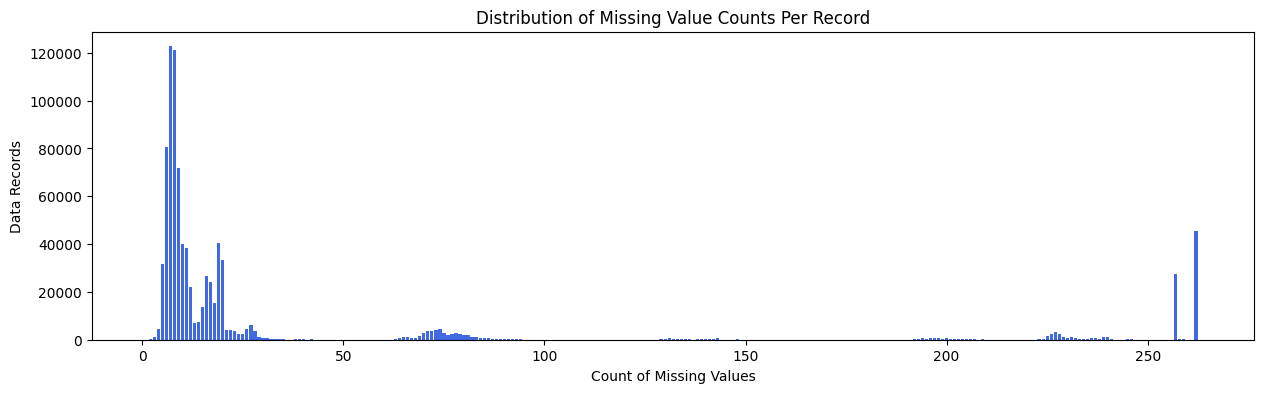

In [95]:
plot_histogram_missing_value_counts_per_record(population)

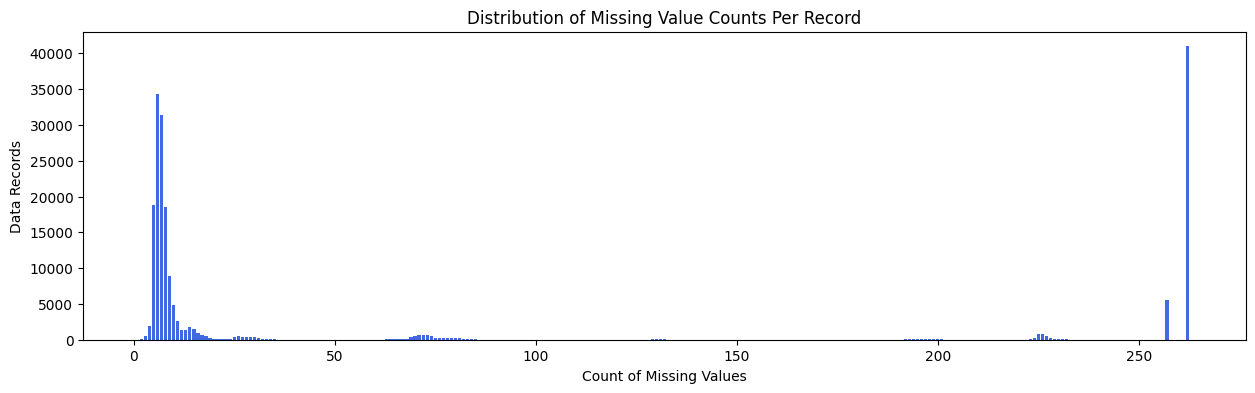

In [96]:
plot_histogram_missing_value_counts_per_record(customer)

In [97]:
print(f"Share of records with less than 10 missing values:"
      f"\nPopulation: {sum(population.isnull().sum(axis=1) < 10) / len(population) * 100:.1f}%"
      f"\nCustomer: {sum(customer.isnull().sum(axis=1) < 10) / len(customer) * 100:.1f}%")

Share of records with less than 10 missing values:
Population: 48.6%
Customer: 59.9%


### Features
The customer data has a slightly lower share of features that contain more than 20% missing values: 2.8% vs. 5.5%

When comparing the missing ratios between both datasets, it is noticeable that:
- `ager_typ` is far more missing in the population dataset which is a hint, that the proportion of older age groups among our customers is higher than in the general population
- the missing rate for various `d19_` features are constantly 22.3% in the population dataset and only 0.7% in our customer dataset
- the correlation between them is with 0.94 very high, so the missing ratios per feature are mostly quite close

In [98]:
population = preprocessing.remove_records_with_insufficient_data(population)
customer = preprocessing.remove_records_with_insufficient_data(customer)

Removed 105801 records with over 33.0% missing feature values.
Removed 51281 records with over 33.0% missing feature values.


In [99]:
customer_missing_ratios = pd.Series(round(customer.isnull().sum() / len(customer) * 100, 1).sort_values(ascending=False), name="customer_missing_ratios")
population_missing_ratios = pd.Series(round(population.isnull().sum() / len(population) * 100, 1).sort_values(ascending=False), name="population_missing_ratios")

print(f"Share of features with more than 20% missing data:"
      f"\nPopulation: {sum(population_missing_ratios >= 20) / len(population.columns) * 100:.1f}%"
      f"\nCustomer: {sum(customer_missing_ratios >= 20) / len(customer.columns) * 100:.1f}%")

Share of features with more than 20% missing data:
Population: 5.5%
Customer: 2.8%


In [100]:
missing_ratios_delta = customer_missing_ratios.reset_index().merge(population_missing_ratios.reset_index(), how="inner", on="index")
missing_ratios_delta["delta_abs"] = round(abs(missing_ratios_delta["customer_missing_ratios"] - missing_ratios_delta["population_missing_ratios"]), 1)
missing_ratios_delta.sort_values("delta_abs", ascending=False).head(15)

,index,customer_missing_ratios,population_missing_ratios,delta_abs
9,extsel992,26.4,70.7,44.3
8,ager_typ,31.1,73.7,42.6
123,d19_konsumtyp,0.7,22.3,21.6
122,d19_telko_online_quote_12,0.7,22.3,21.6
121,d19_soziales,0.7,22.3,21.6
120,d19_versi_online_quote_12,0.7,22.3,21.6
119,d19_gesamt_online_quote_12,0.7,22.3,21.6
118,d19_banken_online_quote_12,0.7,22.3,21.6
125,d19_lotto,0.7,22.3,21.6
124,d19_versand_online_quote_12,0.7,22.3,21.6


In [101]:
print(f"Correlation for the missing value ratios per feature between both datasets: "
      f"{missing_ratios_delta[["customer_missing_ratios", "population_missing_ratios"]].corr().iloc[0, 1]:.2f}")

Correlation for the missing value ratios per feature between both datasets: 0.94


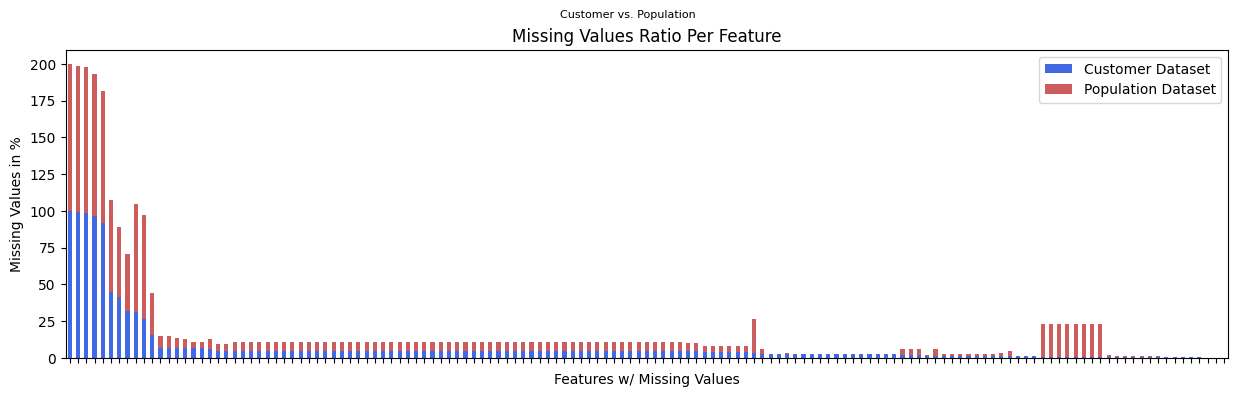

In [102]:
def plot_missing_values_per_feature(df: pd.DataFrame):
    df = df.set_index("index")
    df = df[df["delta_abs"] > 0]
    df = df.drop(columns=["delta_abs"])

    ax = df.plot(kind="bar", stacked=True, figsize=(15, 4), color=["royalblue", "indianred"])
    ax.set_xticklabels([])
    ax.legend(["Customer Dataset", "Population Dataset"])

    plt.xlabel("Features w/ Missing Values")
    plt.ylabel("Missing Values in %")
    plt.title("Missing Values Ratio Per Feature")
    plt.suptitle("Customer vs. Population", fontsize=8)

    plt.show()


plot_missing_values_per_feature(missing_ratios_delta)